# GP Recipes

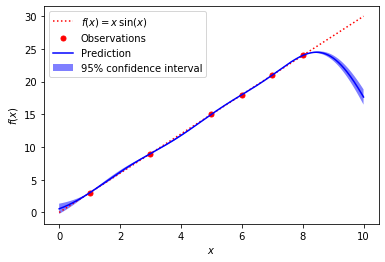

In [1]:
#GP from skikit learn

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
#RBF is squared exponential
from sklearn.gaussian_process.kernels import RBF


#Function to predict
def f(x):
    return 3*x

X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y = f(X).ravel()


x = np.atleast_2d(np.linspace(0, 10, 1000)).T

kernel = RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

gp.fit(X, y)

y_pred, sigma = gp.predict(x, return_std=True)

plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()



---
---
# An implementation of https://doi.org/10.1007/s10915-017-0625-2

### Interpolation:

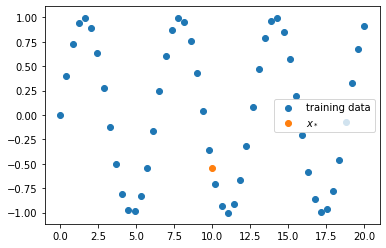

In [11]:
#Here's the data we'll try to interpolate with our homemade GP
N = 50
x = np.linspace(0,20,N)
y = np.sin(x)
plt.scatter(x,y, label='training data')

x_star = 10
plt.scatter(x_star, np.sin(x_star), label='$x_*$')
plt.legend();

$$K(\mathbf{x}, \mathbf{y})=K_{\mathrm{SE}}(\mathbf{x}, \mathbf{y})=\Sigma^{2} \exp \left[-\frac{(\mathbf{x}-\mathbf{y})^{2}}{2 \ell^{2}}\right]$$

In [2]:
def K_se(x,y, Σ=1, l=0.1):
    
    #Hyperparameters:
    #Σ = 1 #for simplicity
    #l = 0.1 #shown to be optimal in FDGP paper
    
    return Σ**2 * np.exp(- (x-y)**2 / (2*l**2))

$$\bar{f}_{*}=\mathbf{k}_{*}^{T} \mathbf{K}^{-1} \mathbf{f}$$
where

$$\mathbf{f}=\left[f\left(\mathbf{x}_{1}\right), \ldots, f\left(\mathbf{x}_{N}\right)\right]^{T}$$
and
$$k_{*, i}=K\left(\mathbf{x}_{*}, x_{i}\right)$$

so I believe
$$\mathbf{k}_{*}^{T} = [K\left(\mathbf{x}_{*}, x_{1}\right), \ldots, K\left(\mathbf{x}_{*}, x_{N}\right)]$$

$$\mathbf{K} \rightarrow K_{i j} \equiv K\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)$$

In [50]:
def f_star(x,y, x_star):
    N = len(x)
    #construct K
    K = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            K[i,j] = K_se(x[i], x[j])

    #Construct K_* and f
    K_star = np.zeros(N)
    f = np.zeros(N)
    for i in range(N):
        K_star[i] = K_se(x_star, x[i])
        f[i] = y[i]
        
    f_star = np.matmul(np.matmul(K_star, K), f.T)
        
    
    return f_star
f_star(x,y,x_star)

-0.3734415411004314

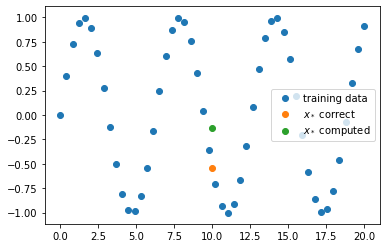

In [27]:
y_star = f_star(x,y, x_star) 

plt.scatter(x,y, label='training data')

plt.scatter(x_star, np.sin(x_star), label='$x_*$ correct')
plt.scatter(x_star, y_star, label='$x_*$ computed')


plt.legend();

# Lets try another example of interpolation with less data

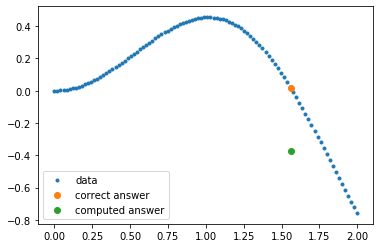

In [46]:
def f(x):
    return x*np.sin(x)*np.cos(x)

#training data
x = np.linspace(0,2,100)
y = f(x)

#correct answer
x_star = 1.56
y_star_correct = f(x_star)

#GP interpolation
y_star = f_star(x,y, x_star)

#plot results
plt.scatter(x,y,marker='.',label="data")
plt.scatter(x_star, y_star_correct, label='correct answer')
plt.scatter(x_star, y_star, label='computed answer')
plt.legend();

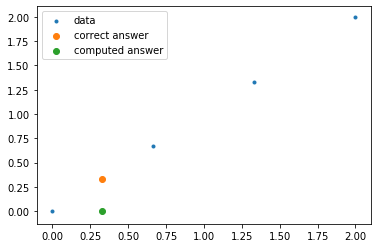

In [51]:
def f(x):
    return x

#training data
x = np.linspace(0,2,4)
y = f(x)

#correct answer
x_star = 0.33
y_star_correct = f(x_star)

#GP interpolation
y_star = f_star(x,y, x_star)

#plot results
plt.scatter(x,y,marker='.',label="data")
plt.scatter(x_star, y_star_correct, label='correct answer')
plt.scatter(x_star, y_star, label='computed answer')
plt.legend();

### Reconstruction

Reconstruction is where we have volume averaged integral quantities: $$\left\langle q_{i}\right\rangle=\frac{1}{\Delta \mathcal{V}_{i}} \int_{\Delta \mathcal{V}_{i}} q\left(\mathbf{x}, t^{n}\right) d \mathcal{V}$$ like in a finite volume method. Our task is to find  the flux at the interface of the cells. This is a change of data type. Going from volume to pointwise value.

This is also seen in finite difference methods. We want to find edge values given integral quantities of cells. 

FVM  - Input: $\frac{1}{\Delta \mathcal{V}_{i}} \int_{\Delta \mathcal{V}_{i}} q\left(\mathbf{x}, t^{n}\right) d \mathcal{V}$ - Output: $q\left(\mathbf{x}, t^{n}\right)$

FDM - Input: $F\left(q_{i}\right)$ - Output: $\hat{F}_{i+\frac{1}{2}}$

(Both require change of data type. Volume quantity to a discrete data point. 

Here we will motify GP interpolation to handle this "change of data types."